In [1]:
from braket.ahs.hamiltonian import Hamiltonian
from braket.ahs.atom_arrangement import AtomArrangement
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation

from braket.timings.time_series import TimeSeries
from braket.ahs.driving_field import DrivingField
from braket.ahs.pattern import Pattern
from braket.ahs.shifting_field import ShiftingField
from braket.ahs.field import Field

from braket.devices import LocalSimulator

import time
import numpy as np

### Imports: BraketAHS Julia package (installing Julia dependencies)

In [2]:
# Importing AHS TN simulator. Installs Julia dependencies automatically. 
# Might take several minutes to complete.
from braket.ahs_tn_simulator.ahs_simulator import LocalSimulatorTN
from braket.ahs_tn_simulator.ahs_utils import get_counts, get_avg_density, show_final_avg_density, get_drive, show_register

In [3]:
def generate_graph(atom_positions, scale=4e-6):
    """
    Helper function to generate a NetworkX graph and Braket AtomArrangement,
    with union-jack (UJ) connectivity, given specified parameters for size of 
    underlying square lattice, and
    atomic positions given as list of tuples [(0,0), (0,1), ...].

    Input:
        atom_positions: Positions of nodes (atoms) in 2D
        scale: [Optional] Lattice spacing a in SI units (defaults to 4um)
    Output:
        nx_graph: NetworkX OrderedGraph of specified type and parameters
    """
    lattice_width = max([x for x,_ in atom_positions])+1
    lattice_height = max([y for _,y in atom_positions])+1
    atom_positions_si = [(x*scale,y*scale) for x,y in atom_positions]
    node_labels = range(len(atom_positions))

    edge_dict = {}
    for i in range(len(atom_positions)):
        x, y = atom_positions[i]
        edge_dict[node_labels[i]] = []
        for j in range(i+1,len(atom_positions)):
            u, v = atom_positions[j]
            if abs(x-u) <= 1 and abs(y-v) <=1:
                edge_dict[node_labels[i]] += [node_labels[j]]

    atoms = AtomArrangement()
    for atom in atom_positions_si:
        atoms.add(atom)
    
    return atoms

## Define AHS program: 
* Input graph for Maximum Independent Set problem
* Protocol schedules: Global detuning, Rabi frequency, Local detuning

In [9]:
np.random.seed(92)

atom_positions = []

# Square lattice nx x ny
nx, ny = 3, 4
for i in range(nx):
    for j in range(ny):
        atom_positions.append((i, j))
        
atoms = generate_graph(atom_positions=atom_positions)

# AHS program hyperparameters
omega_min = 0       
omega_max = 2.5e6 * 2 * np.pi
detuning_min = -9e6 * 2 * np.pi
detuning_max = 7e6 * 2 * np.pi

time_max = 4e-6
time_ramp = 0.15*time_max

time_points = [0, time_ramp, time_max - time_ramp, time_max]
omega_values = [omega_min, omega_max, omega_max, omega_min]
detuning_values = [detuning_min, detuning_min, detuning_max, detuning_max]
phase_values = [0, 0, 0, 0]
pattern = []

drive = get_drive(time_points, omega_values, detuning_values, phase_values)
H = Hamiltonian()
H += drive

# Add zero local detuning
local_detuning = TimeSeries()
local_detuning.put(0., 0.).put(time_max, 0.)
h = Pattern([0] * len(atoms))

shift = ShiftingField(
    magnitude=Field(
        time_series=local_detuning,
        pattern=h
    )
)
H += shift

ahs_program = AnalogHamiltonianSimulation(
    register=atoms, 
    hamiltonian=H
)

# run program on classical device for simulation (without noise)
sv_simulator = LocalSimulator("braket_ahs")
tn_simulator = LocalSimulatorTN() # or equivalently LocalSimulator("braket_ahs_tn")

nshots = 1000

In [10]:
# Statevector AHS simulator

sv_result = sv_simulator.run(ahs_program, shots=nshots, steps=1000, blockade_radius=7e-6).result()

In [11]:
sv_density = get_avg_density(sv_result)
print("Atom density at t=T (SV):", sv_density)

Atom density at t=T (SV): [0.992 0.007 0.005 0.995 0.    0.    0.    0.    0.993 0.006 0.008 0.987]


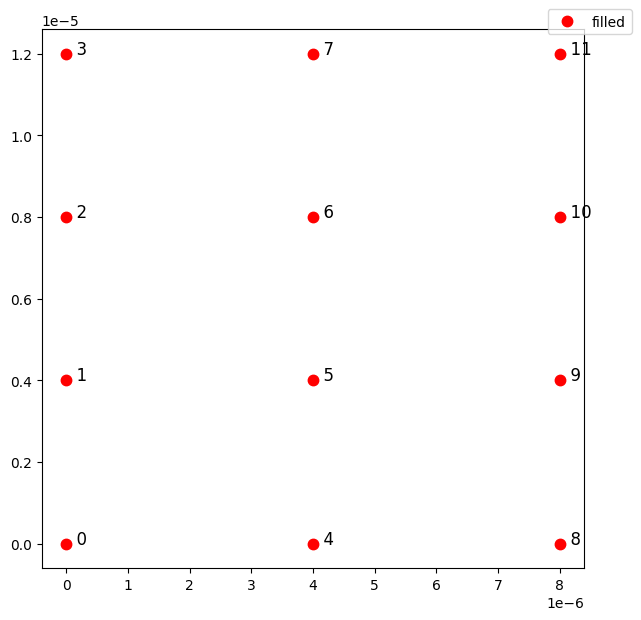

In [12]:
show_register(atoms)

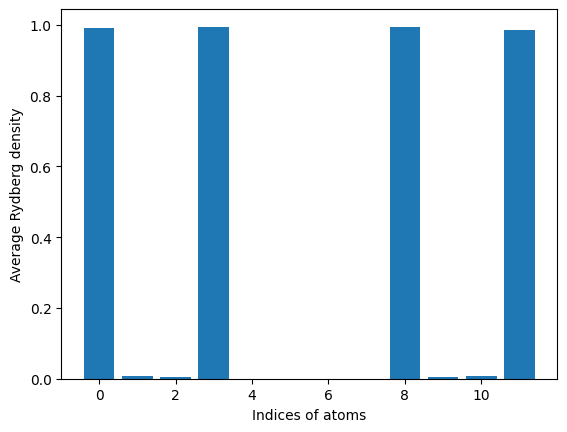

In [13]:
show_final_avg_density(sv_result)

In [14]:
# Tensor Network AHS simulator

# Interaction radius defines a truncation radius for van der Waals interaction Vij.
# The interaction is set to zero in TN simulator Vij = 0 outside of the interaction radius (Rij>interaction_radius).
# This introduces locality to MPS states and speeds up TEBD algorithm.

tn_result = tn_simulator.run(ahs_program, shots=nshots, interaction_radius=15e-6).result()

[ Info: Directory '../experiments' already exists.
[ Info: Preparing initial ψ MPS
[ Info: Generating Trotterized circuit
[ Info: Starting MPS evolution
[ Info: Applying Trotter gates
[ Info: Step: 1, current MPS bond dimension is 1
[ Info: Step: 2, current MPS bond dimension is 1
[ Info: Step: 3, current MPS bond dimension is 1
[ Info: Step: 4, current MPS bond dimension is 1
[ Info: Step: 5, current MPS bond dimension is 3
[ Info: Step: 6, current MPS bond dimension is 4
[ Info: Step: 7, current MPS bond dimension is 4
[ Info: Step: 8, current MPS bond dimension is 5
[ Info: Step: 9, current MPS bond dimension is 5
[ Info: Step: 10, current MPS bond dimension is 5
[ Info: Step: 11, current MPS bond dimension is 4
[ Info: Step: 12, current MPS bond dimension is 5
[ Info: Step: 13, current MPS bond dimension is 4
[ Info: Step: 14, current MPS bond dimension is 5
[ Info: Step: 15, current MPS bond dimension is 5
[ Info: Step: 16, current MPS bond dimension is 5
[ Info: Step: 17, current

In [15]:
tn_density = get_avg_density(tn_result)
print("Atom density at t=T (TN-AHS):", tn_density)

Atom density at t=T (TN-AHS): [0.986 0.013 0.008 0.989 0.    0.002 0.002 0.    0.984 0.011 0.017 0.982]


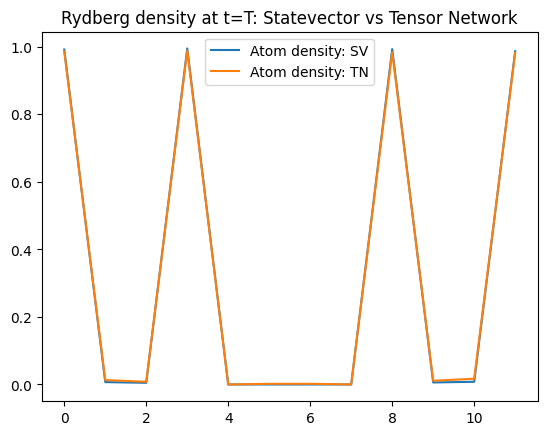

In [16]:
import matplotlib.pyplot as plt
plt.plot(sv_density, label="Atom density: SV")
plt.plot(tn_density, label="Atom density: TN")
plt.title("Rydberg density at t=T: Statevector vs Tensor Network")
plt.legend()